# Imports

In [1]:
import phik
import time
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional

%matplotlib inline

import catboost as cb
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as SklearnGradientBoostingClassifier

# Preprocessing

## Data analysis

In [2]:
data_train = pd.read_csv("data/training.csv", index_col='RefId')

In [3]:
def data_info(df):
    print("Shape:", df.shape)
    print()
    display(df.sample(10))
    print()
    print("Info:")
    df.info()
    print()
    print("Statistics:")
    display(df.describe())
    print()
    print("Missing:")
    display(pd.DataFrame({'% missing values':df.isna().mean()}))
    print()
    print("Duplicates:", df.duplicated().sum())

In [4]:
data_info(data_train)

Shape: (72983, 33)



,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
RefId,,,,,,,,,,,,,,,,,,,,,
17148,0,3/16/2010,MANHEIM,2004,6,TOYOTA,CAMRY 4C,LE,4D SEDAN LE,PURPLE,...,9405.0,11181.0,NaN,NaN,18822,77041,TX,7700.0,0,594
46659,0,2/17/2010,MANHEIM,2008,2,CHEVROLET,UPLANDER FWD V6,LS,PASSENGER EXT 3.5L LS,BLUE,...,14281.0,16105.0,NaN,NaN,5546,33809,FL,7455.0,0,2282
5802,0,7/12/2010,MANHEIM,2004,6,FORD,EXPEDITION 4WD V8,XLT,4D SUV 4.6L XLT,GREEN,...,13574.0,17908.0,NaN,NaN,99750,85040,AZ,10500.0,0,1389
60110,0,12/7/2010,ADESA,2008,2,DODGE,CALIBER,SE,4D WAGON SE,RED,...,12119.0,13475.0,NO,GREEN,25100,78754,TX,7030.0,0,825
8274,0,5/24/2010,MANHEIM,2006,4,CHRYSLER,TOWN & COUNTRY 2WD V,LX,MINIVAN 3.3L,SILVER,...,10062.0,12144.0,NaN,NaN,18880,27542,NC,7130.0,0,1763
17971,0,6/1/2010,OTHER,2004,6,CHEVROLET,TAHOE 2WD,LS,4D SUV 4.8L LS,SILVER,...,12822.0,14501.0,NaN,NaN,1235,84104,UT,10300.0,1,1763
59502,0,8/25/2009,ADESA,2006,3,CHEVROLET,MALIBU MAXX V6 3.5L,LT,4D SEDAN LT,GOLD,...,10883.0,11951.0,NaN,NaN,8655,78754,TX,6100.0,0,1118
20168,0,4/13/2010,OTHER,2004,6,FORD,FOCUS,SE,4D SEDAN SE,GREEN,...,6162.0,7343.0,NaN,NaN,20234,95673,CA,4375.0,0,1155
36481,0,9/30/2009,MANHEIM,2006,3,CHEVROLET,HHR 2.2L I4 MPI,LS,4D SUV 2.2L LS,GREY,...,9354.0,10977.0,NaN,NaN,25100,75236,TX,6625.0,0,671



Info:
<class 'pandas.core.frame.DataFrame'>
Index: 72983 entries, 1 to 73014
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   IsBadBuy                           72983 non-null  int64  
 1   PurchDate                          72983 non-null  object 
 2   Auction                            72983 non-null  object 
 3   VehYear                            72983 non-null  int64  
 4   VehicleAge                         72983 non-null  int64  
 5   Make                               72983 non-null  object 
 6   Model                              72983 non-null  object 
 7   Trim                               70623 non-null  object 
 8   SubModel                           72975 non-null  object 
 9   Color                              72975 non-null  object 
 10  Transmission                       72974 non-null  object 
 11  WheelTypeID                        69814 non-null  f

,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
count,72983.000000,72983.000000,72983.000000,69814.000000,72983.000000,72965.000000,72965.000000,72965.000000,72965.000000,72668.000000,72668.000000,72668.000000,72668.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000
mean,0.122988,2005.343052,4.176644,1.494299,71499.995917,6128.909217,7373.636031,8497.034332,9850.928240,6132.081287,7390.681827,8775.723331,10145.385314,26345.842155,58043.059945,6730.934326,0.025280,1276.580985
std,0.328425,1.731252,1.712210,0.521290,14578.913128,2461.992768,2722.491986,3156.285284,3385.789541,2434.567723,2686.248852,3090.702941,3310.254351,25717.351219,26151.640415,1767.846435,0.156975,598.846788
min,0.000000,2001.000000,0.000000,0.000000,4825.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,835.000000,2764.000000,1.000000,0.000000,462.000000
25%,0.000000,2004.000000,3.000000,1.000000,61837.000000,4273.000000,5406.000000,6280.000000,7493.000000,4275.000000,5414.000000,6536.000000,7784.000000,17212.000000,32124.000000,5435.000000,0.000000,837.000000
50%,0.000000,2005.000000,4.000000,1.000000,73361.000000,6097.000000,7303.000000,8444.000000,9789.000000,6062.000000,7313.000000,8729.000000,10103.000000,19662.000000,73108.000000,6700.000000,0.000000,1155.000000
75%,0.000000,2007.000000,5.000000,2.000000,82436.000000,7765.000000,9021.000000,10651.000000,12088.000000,7736.000000,9013.000000,10911.000000,12309.000000,22808.000000,80022.000000,7900.000000,0.000000,1623.000000
max,1.000000,2010.000000,9.000000,3.000000,115717.000000,35722.000000,36859.000000,39080.000000,41482.000000,35722.000000,36859.000000,39080.000000,41062.000000,99761.000000,99224.000000,45469.000000,1.000000,7498.000000



Missing:


,% missing values
IsBadBuy,0.000000
PurchDate,0.000000
Auction,0.000000
VehYear,0.000000
VehicleAge,0.000000
Make,0.000000
Model,0.000000
Trim,0.032336
SubModel,0.000110
Color,0.000110



Duplicates: 0


## PRIMEUNIT and AUCGUART was delet because there are a lot of missing values

In [5]:
data_train = data_train.drop(['PRIMEUNIT', 'AUCGUART'], axis=1)

In [6]:
cat_cols = ['Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelTypeID', 'WheelType',
            'Nationality', 'Size', 'TopThreeAmericanName', 'VNST', 'IsOnlineSale']

num_cols = ['VehYear', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
            'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
            'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'BYRNO', 'VNZIP1', 'VehBCost', 'WarrantyCost']

target = ['IsBadBuy']

In [7]:
for col in cat_cols:
    data_train[col] = data_train[col].fillna('UNKNOWN')

In [8]:
for col in num_cols:
    data_train[col] = data_train[col].fillna(data_train[col].mean())

In [9]:
data_train['PurchDate'] = pd.to_datetime(data_train['PurchDate'])

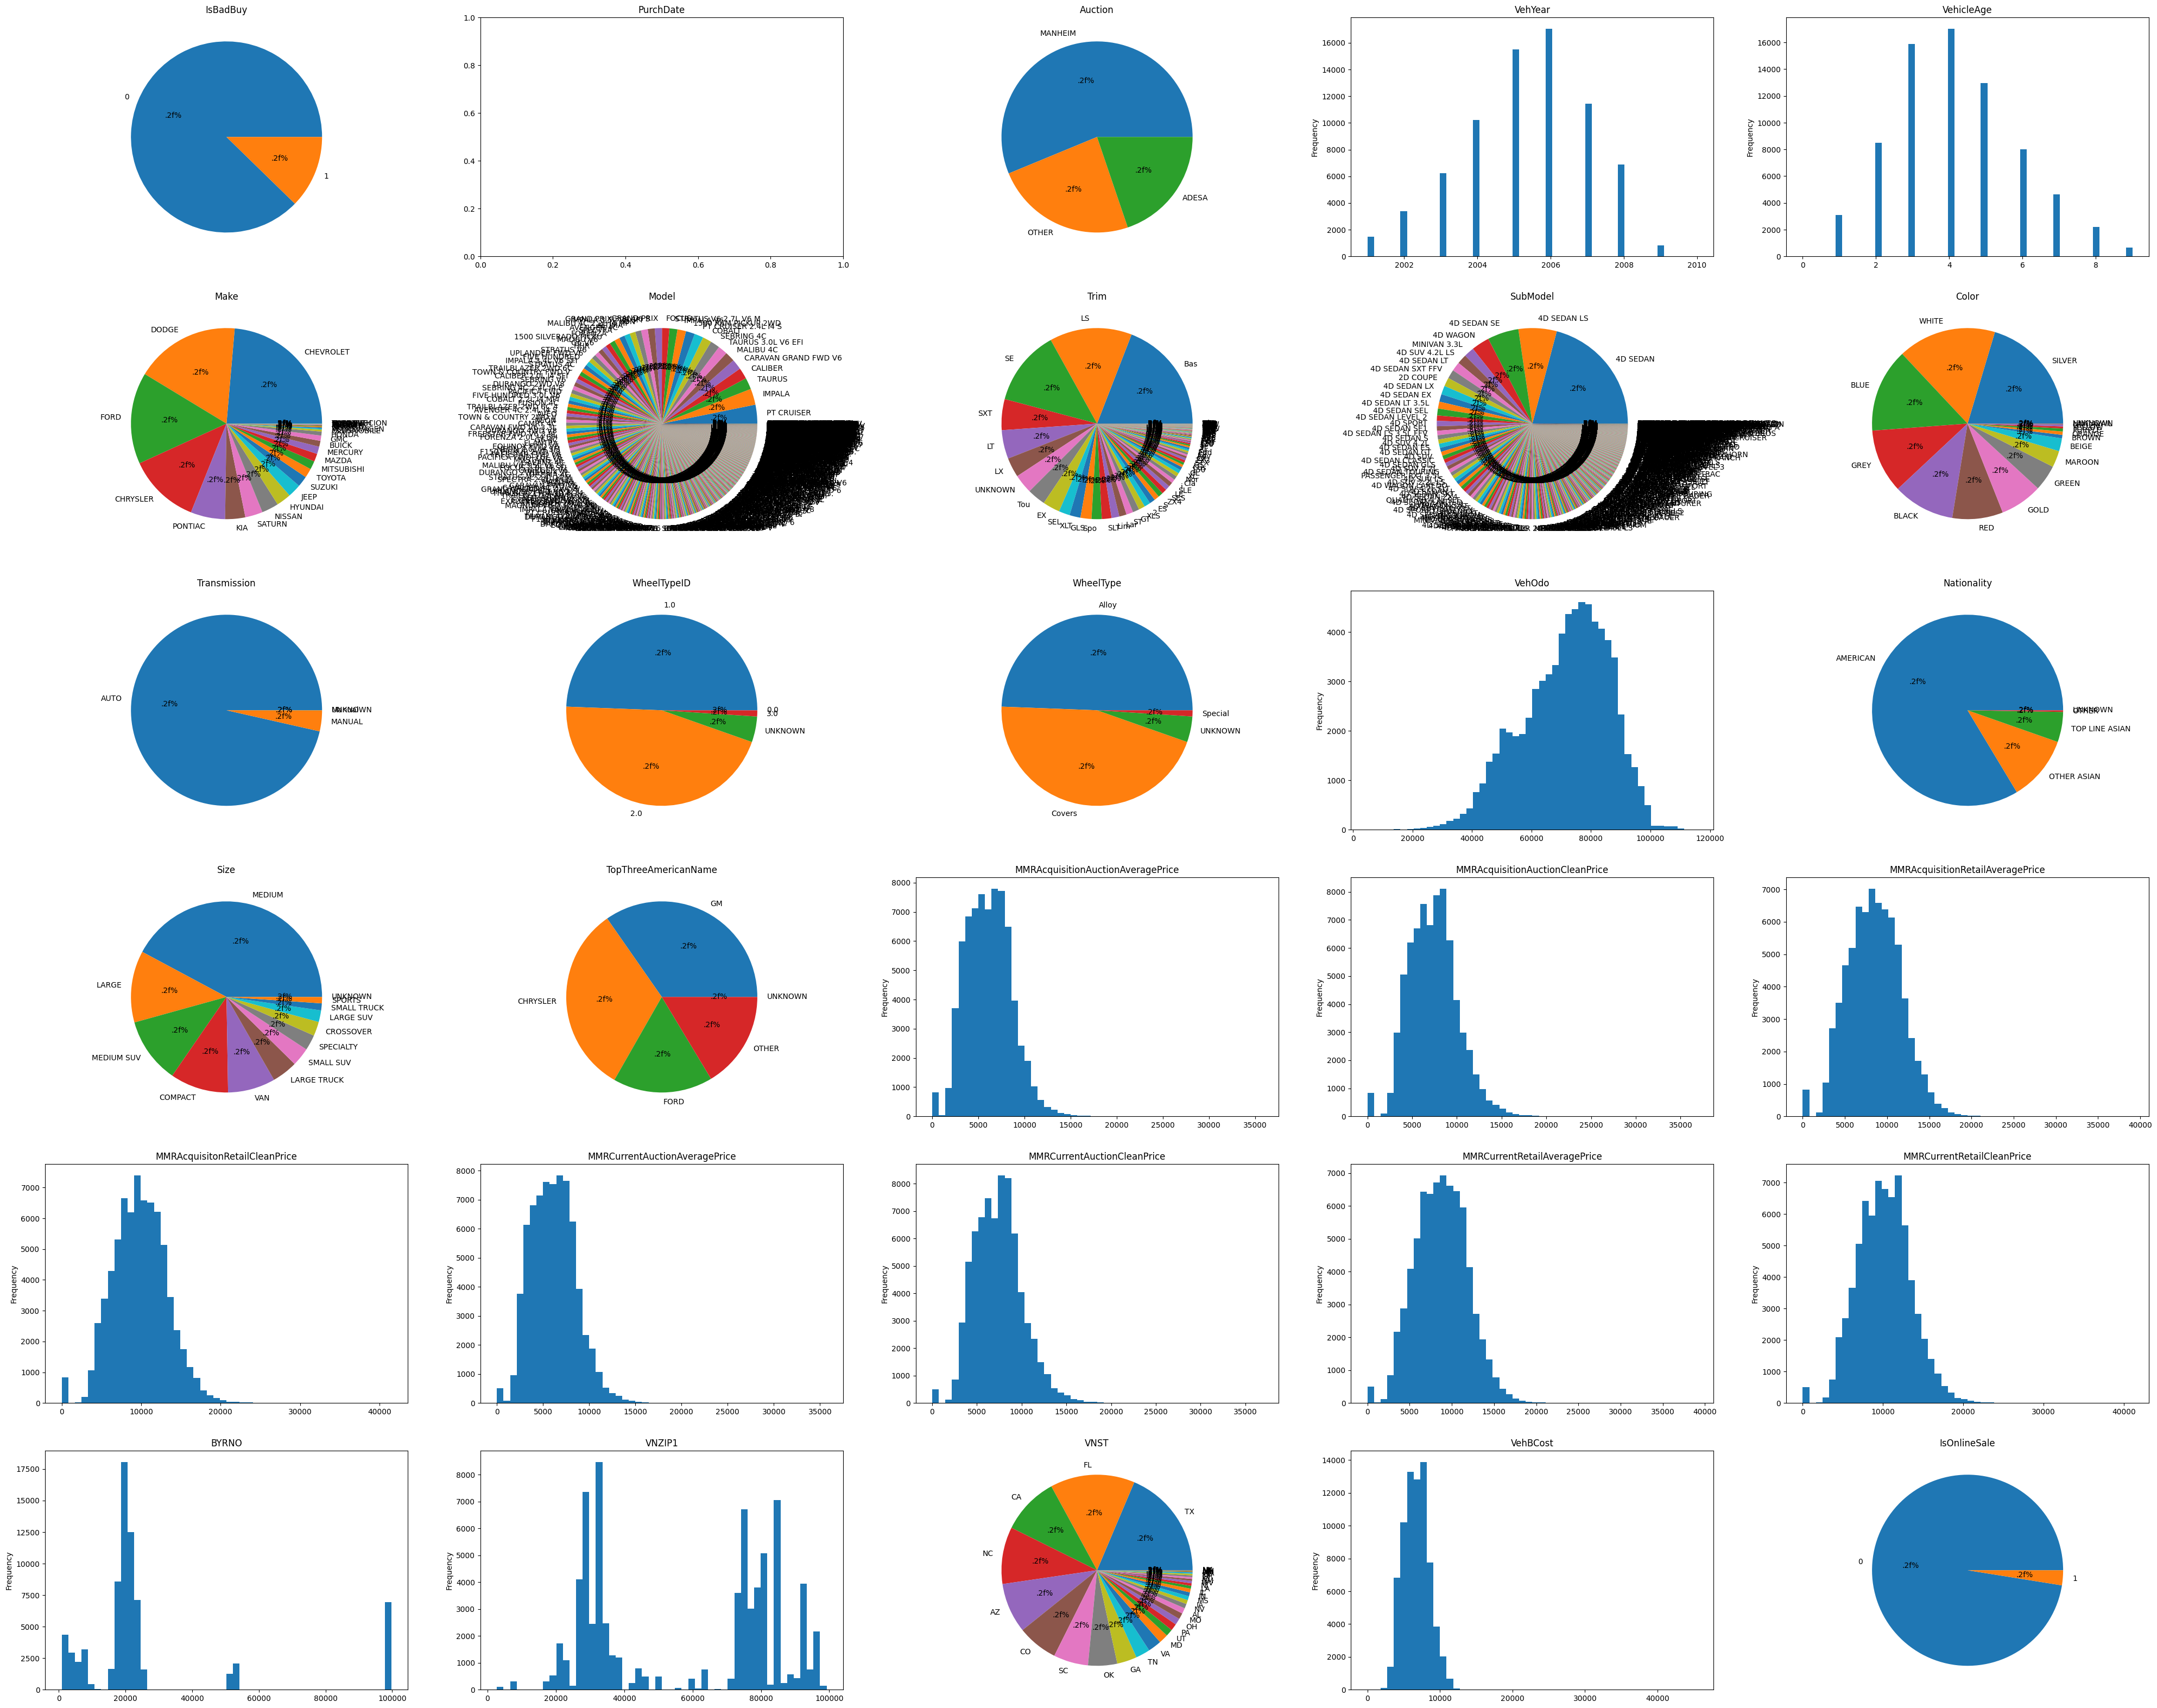

In [10]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(50, 40))
for ax, col in zip(axes.flatten(), data_train.columns):
    ax.set_title(col)
    if col in cat_cols or col in target:
        ax.pie(data_train[col].value_counts(), autopct=".2f%%", labels=data_train[col].value_counts().index)
    elif col in num_cols:
        data_train[col].plot(kind="hist", ec="black", ax=ax, bins=50)

## Feature analysis

In [11]:
px.imshow(data_train.phik_matrix(), text_auto=True, width=2000, height=2000)

interval columns not set, guessing: ['IsBadBuy', 'VehYear', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'BYRNO', 'VNZIP1', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable Model is large: 1063. Are you sure this is not an interval variable? Analysis for pairs of variables including Model can be slow.
  warnings.warn(


### Knowing PurchDate and VahYear, it is possible to calculate VehicleAge, so I throw out VehicalAge, it has too high a correlation with these two features. Removing Transmission and IsOnlineSale, zero correlation with target. I'm also throwing away the Wheeltype. Model is too much, Trim too. SubModel is the same. TopThreeAmericanName is something like Make, so Make is thrown away. VNST also has too much unique data to process it in any way. Deleting BYRNO because it has no practical value.

In [12]:
data_train = data_train.drop(['VehicleAge', 'Transmission', 'WheelTypeID', 'Model', 'SubModel', 'Make', 'Trim', 'VNST',
                              'IsOnlineSale', 'BYRNO'], axis=1)

# Removing these signs by creating new ones, as they have a high correlation with each other

In [13]:
data_train['Diff_AcqAuctionAvg_RetailAvg'] = data_train['MMRAcquisitionAuctionAveragePrice'] - data_train['MMRAcquisitionRetailAveragePrice']
data_train['Diff_CurrentAuctionAvg_RetailAvg'] = data_train['MMRCurrentAuctionAveragePrice'] - data_train['MMRCurrentRetailAveragePrice']

In [14]:
drop_cols = [
    'MMRAcquisitionAuctionCleanPrice',
    'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailCleanPrice'
]
df = data_train.drop(columns=drop_cols)

## Creating new features

In [15]:
data_train['Color'].value_counts()

Color
SILVER       14875
WHITE        12123
BLUE         10347
GREY          7887
BLACK         7627
RED           6257
GOLD          5231
GREEN         3194
MAROON        2046
BEIGE         1584
BROWN          436
ORANGE         415
PURPLE         373
YELLOW         244
OTHER          242
NOT AVAIL       94
UNKNOWN          8
Name: count, dtype: int64

In [16]:
top_5_colors = data_train['Color'].value_counts().index[:5]
data_train['Color'] = data_train['Color'].where(data_train['Color'].isin(top_5_colors), 'OTHER')
data_train['Color'].value_counts()

Color
OTHER     20124
SILVER    14875
WHITE     12123
BLUE      10347
GREY       7887
BLACK      7627
Name: count, dtype: int64

In [17]:
data_train['Size'].value_counts()

Size
MEDIUM         30785
LARGE           8850
MEDIUM SUV      8090
COMPACT         7205
VAN             5854
LARGE TRUCK     3170
SMALL SUV       2276
SPECIALTY       1915
CROSSOVER       1759
LARGE SUV       1433
SMALL TRUCK      864
SPORTS           777
UNKNOWN            5
Name: count, dtype: int64

In [18]:
size_mapping = {
    'MEDIUM': 'MEDIUM',
    'MEDIUM SUV': 'MEDIUM',
    'LARGE': 'LARGE',
    'LARGE TRUCK': 'LARGE',
    'LARGE SUV': 'LARGE',
    'COMPACT': 'SMALL',
    'SMALL SUV': 'SMALL',
    'SMALL TRUCK': 'SMALL',
    'VAN': 'OTHERS',
    'SPECIALTY': 'OTHERS',
    'CROSSOVER': 'OTHERS',
    'SPORTS': 'OTHERS',
    'UNKNOWN': 'OTHERS'
}

data_train['Size'] = data_train['Size'].map(size_mapping)
data_train['Size'].value_counts()

Size
MEDIUM    38875
LARGE     13453
SMALL     10345
OTHERS    10310
Name: count, dtype: int64

In [19]:
for col in data_train.columns:
    if col in cat_cols:
        col_encoded = pd.get_dummies(data_train[col], prefix=col)
        data_train = pd.concat([data_train, col_encoded], axis=1)
        data_train = data_train.drop(col, axis=1)

In [20]:
data_train['PurchYear'] = data_train['PurchDate'].dt.year
data_train['PurchMonth'] = data_train['PurchDate'].dt.month
data_train['PurchDay'] = data_train['PurchDate'].dt.day

data_train = data_train.drop('PurchDate', axis=1)

data_info(data_train)

Shape: (72983, 46)



,IsBadBuy,VehYear,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,...,Size_OTHERS,Size_SMALL,TopThreeAmericanName_CHRYSLER,TopThreeAmericanName_FORD,TopThreeAmericanName_GM,TopThreeAmericanName_OTHER,TopThreeAmericanName_UNKNOWN,PurchYear,PurchMonth,PurchDay
RefId,,,,,,,,,,,,,,,,,,,,,
72128,1,2005,61143,4005.0,5048.0,7079.0,8181.0,4054.000000,4932.000000,7007.000000,...,False,True,False,False,True,False,False,2010,5,27
72113,1,2004,90261,5734.0,6943.0,8881.0,10456.0,5734.000000,6943.000000,8881.000000,...,True,False,True,False,False,False,False,2010,5,20
43142,0,2002,56297,3438.0,4639.0,4213.0,5510.0,2520.000000,3288.000000,3222.000000,...,True,False,True,False,False,False,False,2009,10,21
72423,0,2006,69246,5033.0,5930.0,5936.0,6904.0,12184.000000,13527.000000,13659.000000,...,False,True,False,False,True,False,False,2009,1,7
40000,0,2004,66771,5082.0,6076.0,5989.0,7062.0,5821.000000,6896.000000,6787.000000,...,True,False,False,True,False,False,False,2009,2,5
16300,0,2002,67996,2217.0,3279.0,2894.0,4041.0,2395.000000,3562.000000,3087.000000,...,False,True,False,False,False,True,False,2009,3,25
43867,0,2008,42051,7541.0,8693.0,11640.0,12558.0,7433.000000,8522.000000,11134.000000,...,False,False,True,False,False,False,False,2010,10,13
56794,1,2005,88479,3979.0,4997.0,4797.0,5897.0,4179.000000,5141.000000,5013.000000,...,False,False,False,True,False,False,False,2009,2,24
67032,1,2007,68983,7192.0,8326.0,10588.0,11906.0,6943.000000,8222.000000,10217.000000,...,False,False,False,False,False,True,False,2010,8,18



Info:
<class 'pandas.core.frame.DataFrame'>
Index: 72983 entries, 1 to 73014
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   IsBadBuy                           72983 non-null  int64  
 1   VehYear                            72983 non-null  int64  
 2   VehOdo                             72983 non-null  int64  
 3   MMRAcquisitionAuctionAveragePrice  72983 non-null  float64
 4   MMRAcquisitionAuctionCleanPrice    72983 non-null  float64
 5   MMRAcquisitionRetailAveragePrice   72983 non-null  float64
 6   MMRAcquisitonRetailCleanPrice      72983 non-null  float64
 7   MMRCurrentAuctionAveragePrice      72983 non-null  float64
 8   MMRCurrentAuctionCleanPrice        72983 non-null  float64
 9   MMRCurrentRetailAveragePrice       72983 non-null  float64
 10  MMRCurrentRetailCleanPrice         72983 non-null  float64
 11  VNZIP1                             72983 non-null  i

,IsBadBuy,VehYear,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNZIP1,VehBCost,WarrantyCost,Diff_AcqAuctionAvg_RetailAvg,Diff_CurrentAuctionAvg_RetailAvg,PurchYear,PurchMonth,PurchDay
count,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000
mean,0.122988,2005.343052,71499.995917,6128.909217,7373.636031,8497.034332,9850.928240,6132.081287,7390.681827,8775.723331,10145.385314,58043.059945,6730.934326,1276.580985,-2368.125115,-2643.642043,2009.519600,6.608018,15.667443
std,0.328425,1.731252,14578.913128,2461.689142,2722.156232,3155.896033,3385.371986,2429.308083,2680.445479,3084.025786,3303.102877,26151.640415,1767.846435,598.846788,1369.028057,1304.305836,0.499619,3.415754,8.494650
min,0.000000,2001.000000,4825.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2764.000000,1.000000,462.000000,-7731.000000,-7460.000000,2009.000000,1.000000,1.000000
25%,0.000000,2004.000000,61837.000000,4273.000000,5407.000000,6281.000000,7494.000000,4285.000000,5425.000000,6550.000000,7796.000000,32124.000000,5435.000000,837.000000,-3565.000000,-3644.000000,2009.000000,4.000000,9.000000
50%,0.000000,2005.000000,73361.000000,6098.000000,7305.000000,8446.000000,9790.000000,6076.000000,7328.000000,8753.000000,10114.000000,73108.000000,6700.000000,1155.000000,-2851.000000,-3161.000000,2010.000000,7.000000,16.000000
75%,0.000000,2007.000000,82436.000000,7765.000000,9021.000000,10650.000000,12088.000000,7732.000000,9006.000000,10897.000000,12308.000000,80022.000000,7900.000000,1623.000000,-983.000000,-1084.000000,2010.000000,10.000000,23.000000
max,1.000000,2010.000000,115717.000000,35722.000000,36859.000000,39080.000000,41482.000000,35722.000000,36859.000000,39080.000000,41062.000000,99224.000000,45469.000000,7498.000000,0.000000,40.000000,2010.000000,12.000000,31.000000



Missing:


,% missing values
IsBadBuy,0.0
VehYear,0.0
VehOdo,0.0
MMRAcquisitionAuctionAveragePrice,0.0
MMRAcquisitionAuctionCleanPrice,0.0
MMRAcquisitionRetailAveragePrice,0.0
MMRAcquisitonRetailCleanPrice,0.0
MMRCurrentAuctionAveragePrice,0.0
MMRCurrentAuctionCleanPrice,0.0
MMRCurrentRetailAveragePrice,0.0



Duplicates: 0


# Split the data into train, test, val

In [21]:
n = len(data_train)

train_end = int(n * 0.33)
valid_end = int(n * 0.66)

train = data_train.iloc[:train_end]
valid = data_train.iloc[train_end:valid_end]
test = data_train.iloc[valid_end:]

print(len(train), len(valid), len(test))

24084 24084 24815


In [22]:
X_train = train.drop('IsBadBuy', axis=1)
y_train = train['IsBadBuy']
X_val = valid.drop('IsBadBuy', axis=1)
y_val = valid['IsBadBuy']
X_test = test.drop('IsBadBuy', axis=1)
y_test = test['IsBadBuy']

# Node

In [23]:
class Node:
    def __init__(self, X: np.ndarray, y: np.ndarray, depth: int, is_classifier: bool = True):
        self.X = X
        self.y = y
        self.depth = depth
        self.is_classifier = is_classifier
        self.feature_idx: Optional[int] = None
        self.threshold: Optional[float] = None
        self.left: Optional['Node'] = None
        self.right: Optional['Node'] = None
        self.value: Optional[float] = None
        self.class_counts: Optional[np.ndarray] = None
        
    def compute_criterion(self) -> float:
        if self.is_classifier:
            if len(self.y) == 0:
                return 1.0
            classes, counts = np.unique(self.y, return_counts=True)
            self.class_counts = counts
            probs = counts / len(self.y)
            return 1.0 - np.sum(probs ** 2)
        else:
            return np.std(self.y) ** 2 if len(self.y) > 0 else 0.0

# Decision Tree

In [24]:
class DecisionTreeBase:
    def __init__(self, max_depth: int, is_classifier: bool = True, max_thresholds: Optional[int] = 50, class_weight: Optional[dict] = None):
        self.max_depth = max_depth
        self.is_classifier = is_classifier
        self.max_thresholds = max_thresholds
        self.class_weight = class_weight
        self.root: Optional[Node] = None
        
    def _find_best_split(self, node: Node) -> Tuple[Optional[int], Optional[float], float]:
        best_gain = -np.inf
        best_feature = None
        best_threshold = None
        
        n_features = node.X.shape[1]
        
        for feature_idx in range(n_features): 
            values = node.X[:, feature_idx]
            unique_values = np.unique(values)
            if len(unique_values) == 0:
                continue
            if self.max_thresholds is not None and len(unique_values) > self.max_thresholds:
                thresholds = np.percentile(unique_values, np.linspace(0, 100, self.max_thresholds + 1)[1:-1])
            else:
                thresholds = unique_values
            
            for threshold in thresholds:
                left_mask = node.X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                left_y = node.y[left_mask]
                right_y = node.y[right_mask]
                
                if self.is_classifier:
                    if len(left_y) > 0:
                        classes, counts = np.unique(left_y, return_counts=True)
                        probs = counts / len(left_y)
                        if self.class_weight:
                            weights = np.array([self.class_weight.get(c, 1.0) for c in classes])
                            probs = probs * weights / np.sum(probs * weights)
                        left_gini = 1.0 - np.sum(probs ** 2)
                    else:
                        left_gini = 1.0
                    
                    if len(right_y) > 0:
                        classes, counts = np.unique(right_y, return_counts=True)
                        probs = counts / len(right_y)
                        if self.class_weight:
                            weights = np.array([self.class_weight.get(c, 1.0) for c in classes])
                            probs = probs * weights / np.sum(probs * weights)
                        right_gini = 1.0 - np.sum(probs ** 2)
                    else:
                        right_gini = 1.0
                    
                    gain = node.compute_criterion() - (
                        len(left_y) / len(node.y) * left_gini + 
                        len(right_y) / len(node.y) * right_gini
                    )
                else:
                    left_var = np.var(left_y) if len(left_y) > 0 else 0.0
                    right_var = np.var(right_y) if len(right_y) > 0 else 0.0
                    gain = node.compute_criterion() - (
                        len(left_y) / len(node.y) * left_var + 
                        len(right_y) / len(node.y) * right_var
                    )
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
                    
        return best_feature, best_threshold, best_gain
    
    def _find_randomized_split(self, node: Node, n_random_features: int = None) -> Tuple[Optional[int], Optional[float], float]:
        n_features = node.X.shape[1]
        n_random_features = int(np.sqrt(n_features)) if n_random_features is None else n_random_features
        random_features = np.random.choice(n_features, size=n_random_features, replace=False)
        
        best_gain = -np.inf
        best_feature = None
        best_threshold = None
        
        for feature_idx in random_features:
            values = node.X[:, feature_idx]
            unique_values = np.unique(values)
            if len(unique_values) == 0:
                continue
            if self.max_thresholds is not None and len(unique_values) > self.max_thresholds:
                thresholds = np.percentile(unique_values, np.linspace(0, 100, self.max_thresholds + 1)[1:-1])
            else:
                thresholds = unique_values
            
            for threshold in thresholds:
                left_mask = node.X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                left_y = node.y[left_mask]
                right_y = node.y[right_mask]
                
                if self.is_classifier:
                    if len(left_y) > 0:
                        classes, counts = np.unique(left_y, return_counts=True)
                        probs = counts / len(left_y)
                        if self.class_weight:
                            weights = np.array([self.class_weight.get(c, 1.0) for c in classes])
                            probs = probs * weights / np.sum(probs * weights)
                        left_gini = 1.0 - np.sum(probs ** 2)
                    else:
                        left_gini = 1.0
                    
                    if len(right_y) > 0:
                        classes, counts = np.unique(right_y, return_counts=True)
                        probs = counts / len(right_y)
                        if self.class_weight:
                            weights = np.array([self.class_weight.get(c, 1.0) for c in classes])
                            probs = probs * weights / np.sum(probs * weights)
                        right_gini = 1.0 - np.sum(probs ** 2)
                    else:
                        right_gini = 1.0
                    
                    gain = node.compute_criterion() - (
                        len(left_y) / len(node.y) * left_gini + 
                        len(right_y) / len(node.y) * right_gini
                    )
                else:
                    left_var = np.var(left_y) if len(left_y) > 0 else 0.0
                    right_var = np.var(right_y) if len(right_y) > 0 else 0.0
                    gain = node.compute_criterion() - (
                        len(left_y) / len(node.y) * left_var + 
                        len(right_y) / len(node.y) * right_var
                    )
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
                
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, node: Node, use_randomized: bool = False):
        if node.depth >= self.max_depth or len(np.unique(node.y)) == 1:
            if self.is_classifier:
                node.value = np.bincount(node.y).argmax() if len(node.y) > 0 else 0
            else:
                node.value = np.mean(node.y) if len(node.y) > 0 else 0.0
            return
            
        if use_randomized:
            feature_idx, threshold, gain = self._find_randomized_split(node)
        else:
            feature_idx, threshold, gain = self._find_best_split(node)
            
        if feature_idx is None or gain <= 0:
            if self.is_classifier:
                node.value = np.bincount(node.y).argmax() if len(node.y) > 0 else 0
            else:
                node.value = np.mean(node.y) if len(node.y) > 0 else 0.0
            return
            
        node.feature_idx = feature_idx
        node.threshold = threshold
        
        left_mask = node.X[:, feature_idx] <= threshold
        right_mask = ~left_mask
        
        node.left = Node(node.X[left_mask], node.y[left_mask], node.depth + 1, self.is_classifier)
        node.right = Node(node.X[right_mask], node.y[right_mask], node.depth + 1, self.is_classifier)
        
        self._build_tree(node.left, use_randomized)
        self._build_tree(node.right, use_randomized)
    
    def fit(self, X, y, use_randomized: bool = False, sample_size: Optional[int] = None):
        if not isinstance(X, (pd.DataFrame, np.ndarray)):
            raise TypeError("X must be pandas DataFrame or numpy array")
        if not isinstance(y, (pd.Series, np.ndarray)):
            raise TypeError("y must be pandas Series or numpy array")
            
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
            
        if sample_size is not None and sample_size < len(X):
            indices = np.random.choice(len(X), size=sample_size, replace=False)
            X = X[indices]
            y = y[indices]
            
        self.root = Node(X, y, depth=0, is_classifier=self.is_classifier)
        self._build_tree(self.root, use_randomized)
        return self
    
    def _predict_one(self, x: np.ndarray, node: Node) -> float:
        if node.value is not None:
            return node.value
            
        if x[node.feature_idx] <= node.threshold:
            return self._predict_one(x, node.left)
        return self._predict_one(x, node.right)
    
    def predict(self, X) -> np.ndarray:
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        elif not isinstance(X, np.ndarray):
            raise TypeError("X must be pandas DataFrame or numpy array")
            
        return np.array([self._predict_one(x, self.root) for x in X])

# Decision Tree Classifier

In [25]:
class DecisionTreeClassifier(DecisionTreeBase):
    def __init__(self, max_depth: int, max_thresholds: Optional[int] = 50, class_weight: Optional[dict] = None, extra_random: bool = False, random_state: Optional[int] = None):
        super().__init__(max_depth, is_classifier=True, max_thresholds=max_thresholds, class_weight=class_weight)
        self.classes_ = None
        self.extra_random = extra_random
        self.random_state = random_state
    
    def _find_best_split(self, node):
        if self.extra_random:
            if self.random_state is not None:
                np.random.seed(self.random_state)
                
            X, y = node.X, node.y
            n_features = X.shape[1]
            feature_indices = np.arange(n_features)
            
            best_gain = -np.inf
            best_feature = None
            best_threshold = None
            
            max_thresholds = self.max_thresholds if self.max_thresholds is not None else 50
            
            for feature_idx in feature_indices:
                values = np.unique(X[:, feature_idx])
                if len(values) < 2:
                    continue
                thresholds = np.random.choice(values, size=min(len(values), max_thresholds), replace=False)
                for threshold in thresholds:
                    left_mask = X[:, feature_idx] <= threshold
                    right_mask = ~left_mask
                    if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                        continue
                    
                    left_y = y[left_mask]
                    right_y = y[right_mask]
                    
                    if len(left_y) > 0:
                        classes, counts = np.unique(left_y, return_counts=True)
                        probs = counts / len(left_y)
                        if self.class_weight:
                            weights = np.array([self.class_weight.get(c, 1.0) for c in classes])
                            probs = probs * weights / np.sum(probs * weights)
                        left_gini = 1.0 - np.sum(probs ** 2)
                    else:
                        left_gini = 1.0
                    
                    if len(right_y) > 0:
                        classes, counts = np.unique(right_y, return_counts=True)
                        probs = counts / len(right_y)
                        if self.class_weight:
                            weights = np.array([self.class_weight.get(c, 1.0) for c in classes])
                            probs = probs * weights / np.sum(probs * weights)
                        right_gini = 1.0 - np.sum(probs ** 2)
                    else:
                        right_gini = 1.0
                    
                    gain = node.compute_criterion() - (
                        len(left_y) / len(y) * left_gini + 
                        len(right_y) / len(y) * right_gini
                    )
                    
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature_idx
                        best_threshold = threshold
            
            return best_feature, best_threshold, best_gain
        else:
            return super()._find_best_split(node)
    
    def fit(self, X, y, use_randomized: bool = False, sample_size: Optional[int] = None):
        self.classes_ = np.unique(y)
        if len(X) == 0 or len(y) == 0:
            raise ValueError("Sample is empty")
        return super().fit(X, y, use_randomized=use_randomized, sample_size=sample_size)
        
    def predict_proba(self, X) -> np.ndarray:
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        elif not isinstance(X, np.ndarray):
            raise TypeError("X must be pandas DataFrame or numpy array")
        if self.root is None:
            raise RuntimeError("Model not fit")
        
        def get_proba(node: Node, x: np.ndarray) -> np.ndarray:
            if node is None:
                return np.ones(len(self.classes_)) / len(self.classes_)
                
            if node.value is not None:
                probs = np.zeros(len(self.classes_))
                if node.class_counts is not None:
                    counts = node.class_counts
                    total = np.sum(counts)
                    for i, cls in enumerate(np.unique(node.y)):
                        idx = np.where(self.classes_ == cls)[0]
                        if len(idx) > 0:
                            probs[idx[0]] += counts[i] / total
                else:
                    probs[int(node.value)] = 1.0
                return probs
            
            if x[node.feature_idx] <= node.threshold:
                return get_proba(node.left, x)
            return get_proba(node.right, x)
        
        return np.array([get_proba(self.root, x) for x in X])

# Decision Tree Regressor

In [26]:
class DecisionTreeRegressor(DecisionTreeBase):
    def __init__(self, max_depth: int, max_thresholds: int = 20):
        super().__init__(max_depth, is_classifier=False, max_thresholds=max_thresholds)
        
    def fit(self, X, y, use_randomized: bool = False, sample_size: Optional[int] = None):
        return super().fit(X, y, use_randomized=use_randomized, sample_size=sample_size)

# Extra Trees Classifier

In [27]:
class ExtraRandomizedTree(DecisionTreeClassifier):
    def __init__(self, max_depth: int, max_thresholds: int = 20):
        super().__init__(max_depth, max_thresholds=max_thresholds)
        
    def fit(self, X, y, sample_size: Optional[int] = None):
        self.classes_ = np.unique(y)
        return super().fit(X, y, use_randomized=True, sample_size=sample_size)

# Tree's results

In [28]:
results = []

models = [
    (DecisionTreeClassifier(max_depth=10, max_thresholds=None), 'Custom DecisionTreeClassifier'),
    (ExtraRandomizedTree(max_depth=10, max_thresholds=None), 'Custom ExtraRandomizedTree'),
    (SklearnDecisionTreeClassifier(max_depth=10), 'Sklearn DecisionTreeClassifier')
]

In [29]:
def evaluate_model(model, model_name, X_train, y_train, X_val, y_val, sample_size=None, cat_features=None):
    start_time = time.time()
    
    if isinstance(model, (lgb.LGBMClassifier, cb.CatBoostClassifier, xgb.XGBClassifier, SklearnDecisionTreeClassifier, SklearnRandomForestClassifier, SklearnGradientBoostingClassifier)):
        if isinstance(model, cb.CatBoostClassifier):
            model.fit(X_train, y_train, cat_features=cat_features, verbose=False)
        else:
            model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train, sample_size=sample_size)
    
    train_time = time.time() - start_time
    
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='binary', zero_division=0)
    auc = roc_auc_score(y_val, y_pred_proba)
    gini_score = 2 * auc - 1
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Gini Score': gini_score,
        'Training Time (s)': train_time
    }

In [30]:
for model, model_name in models:
    result = evaluate_model(model, model_name, X_train, y_train, X_val, y_val, sample_size=None)
    results.append(result)

In [31]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,F1-Score,Gini Score,Training Time (s)
0,Custom DecisionTreeClassifier,0.885526,0.231391,0.130367,225.856793
1,Custom ExtraRandomizedTree,0.878342,0.165242,0.084536,31.743776
2,Sklearn DecisionTreeClassifier,0.885609,0.238740,0.335892,0.250605


# Random Forest Classifier

In [32]:
class RandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=20, max_thresholds: Optional[int] = 20, class_weight: Optional[dict] = None, random_state: Optional[int] = None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_thresholds = max_thresholds
        self.class_weight = class_weight
        self.random_state = random_state
        self.trees = []
        self.classes_ = None
        
    def fit(self, X, y, sample_size: Optional[int] = None):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
            
        self.classes_ = np.unique(y)
        n_samples = X.shape[0]
        
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        for i in range(self.n_estimators):
            if self.random_state is not None:
                seed = self.random_state + i
                np.random.seed(seed)
                
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            
            if sample_size is not None and sample_size < len(X_sample):
                sub_indices = np.random.choice(len(X_sample), size=sample_size, replace=False)
                X_sample = X_sample[sub_indices]
                y_sample = y_sample[sub_indices]
                
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                max_thresholds=self.max_thresholds,
                class_weight=self.class_weight
            )
            tree.fit(X_sample, y_sample, use_randomized=True)
            self.trees.append(tree)
            
        return self
    
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
            
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions)
    
    def predict_proba(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
            
        proba = np.mean([tree.predict_proba(X) for tree in self.trees], axis=0)
        return proba

In [33]:
class_weights = {0: 1.0, 1: 100.0}
random_seed = 42
models = [
    (RandomForestClassifier(n_estimators=100, max_depth=20, max_thresholds=20, class_weight=class_weights, random_state=random_seed), 'Custom RandomForestClassifier'),
    (SklearnRandomForestClassifier(n_estimators=100, max_depth=20, class_weight=class_weights, random_state=random_seed), 'Sklearn RandomForestClassifier')
]

In [34]:
for model, model_name in models:
    result = evaluate_model(model, model_name, X_train, y_train, X_val, y_val, sample_size=None)
    results.append(result)

In [35]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,F1-Score,Gini Score,Training Time (s)
0,Custom DecisionTreeClassifier,0.885526,0.231391,0.130367,225.856793
1,Custom ExtraRandomizedTree,0.878342,0.165242,0.084536,31.743776
2,Sklearn DecisionTreeClassifier,0.885609,0.238740,0.335892,0.250605
3,Custom RandomForestClassifier,0.880875,0.000000,0.171809,289.176359
4,Sklearn RandomForestClassifier,0.594669,0.285149,0.359033,4.338463


# Gradient Boosting Decision Tree Classifier

In [36]:
class GBDTClassifier:
    def __init__(self, max_depth: int = 3, number_of_trees: int = 50, max_features: Optional[str] = 'sqrt', learning_rate: float = 0.1, random_state: Optional[int] = None):
        self.max_depth = max_depth
        self.number_of_trees = number_of_trees
        self.max_features = max_features
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.trees = []
        self.initial_logit = None
        self.classes_ = [0, 1]
        
    def _sigmoid(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))
    
    def _compute_gradient(self, y_true: np.ndarray, y_pred_proba: np.ndarray) -> np.ndarray:
        return y_pred_proba - y_true
    
    def _get_max_features(self, n_features: int) -> int:
        if self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            return int(np.log2(n_features))
        elif isinstance(self.max_features, int):
            return min(self.max_features, n_features)
        else:
            return n_features
    
    def fit(self, X, y, sample_size: Optional[int] = None):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
            
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        n_samples, n_features = X.shape
        max_features = self._get_max_features(n_features)

        self.initial_logit = np.log(np.mean(y) / (1 - np.mean(y))) if np.mean(y) > 0 else 0.0
        current_logits = np.full(n_samples, self.initial_logit)
        
        for i in range(self.number_of_trees):
            current_proba = self._sigmoid(current_logits)

            residuals = -self._compute_gradient(y, current_proba)

            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                max_thresholds=20
            )

            if sample_size is not None and sample_size < n_samples:
                indices = np.random.choice(n_samples, size=sample_size, replace=False)
                X_sample = X[indices]
                residuals_sample = residuals[indices]
            else:
                X_sample = X
                residuals_sample = residuals
                
            tree.fit(X_sample, residuals_sample, use_randomized=True)
            self.trees.append(tree)

            tree_predictions = tree.predict(X)
            current_logits += self.learning_rate * tree_predictions
            
        return self
    
    def predict_proba(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
            
        logits = np.full(X.shape[0], self.initial_logit)
        for tree in self.trees:
            logits += self.learning_rate * tree.predict(X)
            
        proba = self._sigmoid(logits)
        return np.vstack([1 - proba, proba]).T
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)

In [37]:
class_weights = {0: 1.0, 1: 100.0}
random_seed = 42
models = [
    (GBDTClassifier(max_depth=3, number_of_trees=50, max_features='sqrt', learning_rate=0.1, random_state=random_seed), 'Custom GBDT'),
    (SklearnGradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, max_features='sqrt', random_state=random_seed), 'Sklearn GBDT')
]

In [38]:
for model, model_name in models:
    result = evaluate_model(model, model_name, X_train, y_train, X_val, y_val)
    results.append(result)

In [39]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,F1-Score,Gini Score,Training Time (s)
0,Custom DecisionTreeClassifier,0.885526,0.231391,0.130367,225.856793
1,Custom ExtraRandomizedTree,0.878342,0.165242,0.084536,31.743776
2,Sklearn DecisionTreeClassifier,0.885609,0.238740,0.335892,0.250605
3,Custom RandomForestClassifier,0.880875,0.000000,0.171809,289.176359
4,Sklearn RandomForestClassifier,0.594669,0.285149,0.359033,4.338463
5,Custom GBDT,0.880875,0.000000,0.423583,9.228829
6,Sklearn GBDT,0.890384,0.197080,0.451627,0.724371


# Creating cat_features

In [40]:
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# LGB Best Parameters

In [41]:
lgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [20, 50],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
lgb_model = lgb.LGBMClassifier(random_state=random_seed, verbose=-1)
lgb_search = RandomizedSearchCV(lgb_model, lgb_params, n_iter=10, scoring='roc_auc', cv=3, random_state=random_seed)
lgb_search.fit(X_train, y_train)
lgb_best = lgb_search.best_estimator_
lgb_search.best_params_

{'subsample': 1.0,
 'num_leaves': 63,
 'n_estimators': 200,
 'min_child_samples': 20,
 'max_depth': 3,
 'learning_rate': 0.1,
 'colsample_bytree': 0.8}

# CatBoost Best Parameters

In [42]:
cb_params = {
    'iterations': [50, 100, 200],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.5, 1.0],
    'border_count': [32, 64]
}
cb_model = cb.CatBoostClassifier(random_state=random_seed, verbose=False, cat_features=cat_features)
cb_search = RandomizedSearchCV(cb_model, cb_params, n_iter=10, scoring='roc_auc', cv=3, random_state=random_seed)
cb_search.fit(X_train, y_train)
cb_best = cb_search.best_estimator_
cb_search.best_params_

{'learning_rate': 0.1,
 'l2_leaf_reg': 1,
 'iterations': 50,
 'depth': 7,
 'border_count': 64,
 'bagging_temperature': 0.5}

# XGB Best Parameters

In [43]:
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2]
}
xgb_model = xgb.XGBClassifier(booster='dart', random_state=random_seed)
xgb_search = RandomizedSearchCV(xgb_model, xgb_params, n_iter=10, scoring='roc_auc', cv=3, random_state=random_seed)
xgb_search.fit(X_train, y_train)
xgb_best = xgb_search.best_estimator_
xgb_search.best_params_

{'subsample': 0.8,
 'reg_lambda': 1,
 'reg_alpha': 0,
 'n_estimators': 200,
 'max_depth': 7,
 'learning_rate': 0.1,
 'colsample_bytree': 1.0}

# Results

In [44]:
models = [
    (lgb_best, 'LightGBM'),
    (cb_best, 'CatBoost'),
    (xgb_best, 'XGBoost (DART)')
]

In [45]:
for model, model_name in models:
    result = evaluate_model(model, model_name, X_train, y_train, X_val, y_val, cat_features=cat_features)
    results.append(result)

In [46]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,F1-Score,Gini Score,Training Time (s)
0,Custom DecisionTreeClassifier,0.885526,0.231391,0.130367,225.856793
1,Custom ExtraRandomizedTree,0.878342,0.165242,0.084536,31.743776
2,Sklearn DecisionTreeClassifier,0.885609,0.238740,0.335892,0.250605
3,Custom RandomForestClassifier,0.880875,0.000000,0.171809,289.176359
4,Sklearn RandomForestClassifier,0.594669,0.285149,0.359033,4.338463
5,Custom GBDT,0.880875,0.000000,0.423583,9.228829
6,Sklearn GBDT,0.890384,0.197080,0.451627,0.724371
7,LightGBM,0.890923,0.240532,0.454323,0.333174
8,CatBoost,0.891961,0.235605,0.457977,0.388190
9,XGBoost (DART),0.892833,0.260670,0.448499,33.829864


# Best model training

In [47]:
cb_best = cb.CatBoostClassifier(
    **cb_search.best_params_,
    random_state=42,
    verbose=False,
    cat_features=cat_features
)

datasets = {
    'train': (X_train, y_train),
    'valid': (X_val, y_val),
    'test': (X_test, y_test)
}

In [48]:
def evaluate_model_on_datasets(model, model_name: str, datasets: Dict[str, Tuple[pd.DataFrame, pd.Series]], sample_size: Optional[int] = None, cat_features: Optional[List[str]] = None) -> List[Dict]:
    results = []
    for data_name, (X, y) in datasets.items():
        start_time = time.time()
        if data_name == 'train':
            if isinstance(model, ExtraTreesClassifier):
                model.fit(X, y)
            elif 'catboost' in model_name.lower():
                model.fit(X, y, cat_features=cat_features, verbose=False)
            else:
                model.fit(X, y, sample_size=sample_size)
        train_time = time.time() - start_time if data_name == 'train' else 0
        
        y_pred = model.predict(X)
        y_pred_proba = model.predict_proba(X)[:, 1]
        
        accuracy = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average='binary', zero_division=0)
        auc = roc_auc_score(y, y_pred_proba)
        gini_score = 2 * auc - 1
        
        results.append({
            'Model': model_name,
            'Dataset': data_name,
            'Accuracy': accuracy,
            'F1-Score': f1,
            'Gini Score': gini_score,
            'Training Time (s)': train_time,
        })
    return results

In [49]:
results_best = evaluate_model_on_datasets(cb_best, 'CatBoost', datasets, cat_features=cat_features)
results_best_df = pd.DataFrame(results_best)
results_best_df

,Model,Dataset,Accuracy,F1-Score,Gini Score,Training Time (s)
0,CatBoost,train,0.938552,0.935034,0.939315,0.389097
1,CatBoost,valid,0.891961,0.235605,0.457977,0.000000
2,CatBoost,test,0.906871,0.496624,0.583768,0.000000


# Extra Trees Classifier

In [50]:
class CustomExtraTreesClassifier:
    def __init__(self, n_estimators=100, max_depth=10, max_features='sqrt', max_thresholds=20, class_weight=None, bootstrap=True, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.max_thresholds = max_thresholds
        self.class_weight = class_weight
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.trees = []
        self.classes_ = None
    
    def _get_max_features(self, n_features):
        if self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            return int(np.log2(n_features))
        elif isinstance(self.max_features, int):
            return min(self.max_features, n_features)
        else:
            return n_features
    
    def fit(self, X, y, sample_size=None):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
            
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        max_features = self._get_max_features(n_features)
        
        for _ in range(self.n_estimators):
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                max_thresholds=self.max_thresholds,
                class_weight=self.class_weight,
                extra_random=True,
                random_state=np.random.randint(0, 1000000)
            )

            if self.bootstrap:
                indices = np.random.choice(n_samples, n_samples, replace=True)
                X_subset, y_subset = X[indices], y[indices]
            else:
                X_subset, y_subset = X, y
                
            tree.fit(X_subset, y_subset, use_randomized=True)
            self.trees.append(tree)
            
        return self
    
    def predict_proba(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
            
        probs = np.zeros((X.shape[0], len(self.classes_)))
        for tree in self.trees:
            tree_probs = tree.predict_proba(X)
            probs += tree_probs
        probs /= self.n_estimators
        return probs
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

In [51]:
if cat_features:
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train[cat_features] = encoder.fit_transform(X_train[cat_features])
    X_val[cat_features] = encoder.transform(X_val[cat_features])
    X_test[cat_features] = encoder.transform(X_test[cat_features])

In [52]:
custom_et_model = CustomExtraTreesClassifier(
    n_estimators=100,
    max_depth=10,
    max_features='sqrt',
    max_thresholds=20,
    class_weight={0: 1.0, 1: 100.0},
    bootstrap=True,
    random_state=42
)
custom_et_results = evaluate_model_on_datasets(custom_et_model, 'Custom ExtraTrees', datasets)

In [53]:
sklearn_et_model = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=10,
    max_features='sqrt',
    class_weight={0: 1.0, 1: 100.0},
    bootstrap=True,
    random_state=42
)
sklearn_et_results = evaluate_model_on_datasets(sklearn_et_model, 'Sklearn ExtraTrees', datasets)

In [54]:
all_results = custom_et_results + sklearn_et_results
all_results_df = pd.DataFrame(all_results)
all_results_df

,Model,Dataset,Accuracy,F1-Score,Gini Score,Training Time (s)
0,Custom ExtraTrees,train,0.614547,0.490250,0.373549,166.688295
1,Custom ExtraTrees,valid,0.780933,0.194504,0.107153,0.000000
2,Custom ExtraTrees,test,0.756115,0.222108,0.154536,0.000000
3,Sklearn ExtraTrees,train,0.500564,0.666918,0.915706,1.130984
4,Sklearn ExtraTrees,valid,0.119208,0.212788,0.283458,0.000000
5,Sklearn ExtraTrees,test,0.132621,0.233749,0.359377,0.000000
